In [1]:
# Importing the required libraries
import numpy as np 
from numpy import percentile
import pandas as pd 
from sklearn import preprocessing,model_selection,metrics
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-may-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2022/train.csv
/kaggle/input/tabular-playground-series-may-2022/test.csv


### Loading the dataset

In [42]:
train_df = pd.read_csv("/kaggle/input/tabular-playground-series-may-2022/train.csv")
test_df = pd.read_csv("/kaggle/input/tabular-playground-series-may-2022/test.csv")

### Understanding the training data 

In [3]:
train_df.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

In [5]:
train_df.describe()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
count,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,...,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000
mean,449999.500000,-0.000286,0.001165,0.001174,-0.001368,-0.000571,0.000284,-0.000709,2.031460,2.057998,...,-0.156307,-0.009273,-0.369459,-0.342738,0.176549,0.357591,-0.380876,0.345661,1.002654,0.486488
std,259807.765473,0.998888,0.999193,1.000514,1.000175,1.000167,0.999875,0.999942,1.656172,1.590955,...,2.484706,2.450797,2.453405,2.386941,2.416959,2.476020,238.773054,0.475584,0.818989,0.499818
min,0.000000,-4.599856,-4.682199,-4.642676,-4.658816,-4.748501,-4.750214,-4.842919,0.000000,0.000000,...,-13.310146,-11.853530,-12.301097,-11.416189,-11.918306,-14.300577,-1229.753052,0.000000,0.000000,0.000000
25%,224999.750000,-0.675490,-0.675162,-0.674369,-0.676114,-0.675909,-0.673437,-0.674876,1.000000,1.000000,...,-1.820063,-1.645585,-2.019739,-1.955956,-1.440424,-1.261598,-159.427418,0.000000,0.000000,0.000000
50%,449999.500000,0.001144,0.002014,0.002218,-0.002227,-0.001662,-0.000438,-0.001492,2.000000,2.000000,...,-0.152668,0.030850,-0.390966,-0.340746,0.160912,0.404212,-0.519808,0.000000,1.000000,0.000000
75%,674999.250000,0.674337,0.675021,0.677505,0.672544,0.673789,0.675028,0.674749,3.000000,3.000000,...,1.507071,1.661676,1.255408,1.266673,1.795928,2.028219,158.987357,1.000000,2.000000,1.000000
max,899999.000000,4.749301,4.815699,4.961982,4.454920,4.948983,4.971881,4.822668,15.000000,16.000000,...,14.455426,11.344080,12.247100,12.389844,12.529179,12.913041,1229.562577,1.000000,2.000000,1.000000


<AxesSubplot:xlabel='target', ylabel='count'>

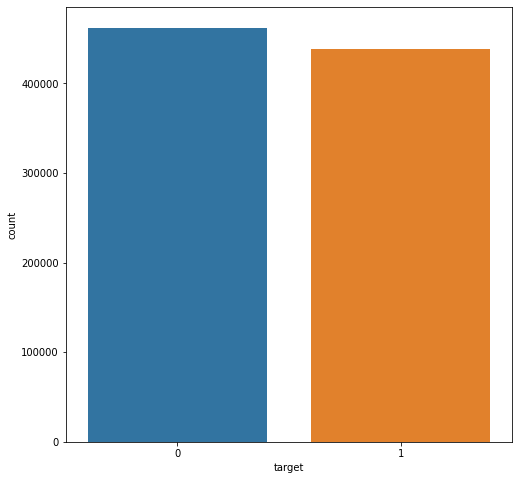

In [6]:
plt.figure(figsize=(8,8))
sns.countplot(x=train_df.target)

### The dataset is balanced. Checking if there are any missing values.

In [7]:
train_df.isnull().sum()

id        0
f_00      0
f_01      0
f_02      0
f_03      0
f_04      0
f_05      0
f_06      0
f_07      0
f_08      0
f_09      0
f_10      0
f_11      0
f_12      0
f_13      0
f_14      0
f_15      0
f_16      0
f_17      0
f_18      0
f_19      0
f_20      0
f_21      0
f_22      0
f_23      0
f_24      0
f_25      0
f_26      0
f_27      0
f_28      0
f_29      0
f_30      0
target    0
dtype: int64

### There are no missing values in the dataset.

#### Plotting a histogram for each numerical column

In [8]:
numerical_columns = [col for col in train_df.columns if train_df[col].dtypes!='object' and col not in ('id','target')]
cat_column = [col for col in train_df.columns if train_df[col].dtypes=='object']

In [9]:
len(numerical_columns),len(cat_column)

(30, 1)

array([[<AxesSubplot:title={'center':'f_00'}>,
        <AxesSubplot:title={'center':'f_01'}>,
        <AxesSubplot:title={'center':'f_02'}>,
        <AxesSubplot:title={'center':'f_03'}>,
        <AxesSubplot:title={'center':'f_04'}>],
       [<AxesSubplot:title={'center':'f_05'}>,
        <AxesSubplot:title={'center':'f_06'}>,
        <AxesSubplot:title={'center':'f_07'}>,
        <AxesSubplot:title={'center':'f_08'}>,
        <AxesSubplot:title={'center':'f_09'}>],
       [<AxesSubplot:title={'center':'f_10'}>,
        <AxesSubplot:title={'center':'f_11'}>,
        <AxesSubplot:title={'center':'f_12'}>,
        <AxesSubplot:title={'center':'f_13'}>,
        <AxesSubplot:title={'center':'f_14'}>],
       [<AxesSubplot:title={'center':'f_15'}>,
        <AxesSubplot:title={'center':'f_16'}>,
        <AxesSubplot:title={'center':'f_17'}>,
        <AxesSubplot:title={'center':'f_18'}>,
        <AxesSubplot:title={'center':'f_19'}>],
       [<AxesSubplot:title={'center':'f_20'}>,
        <

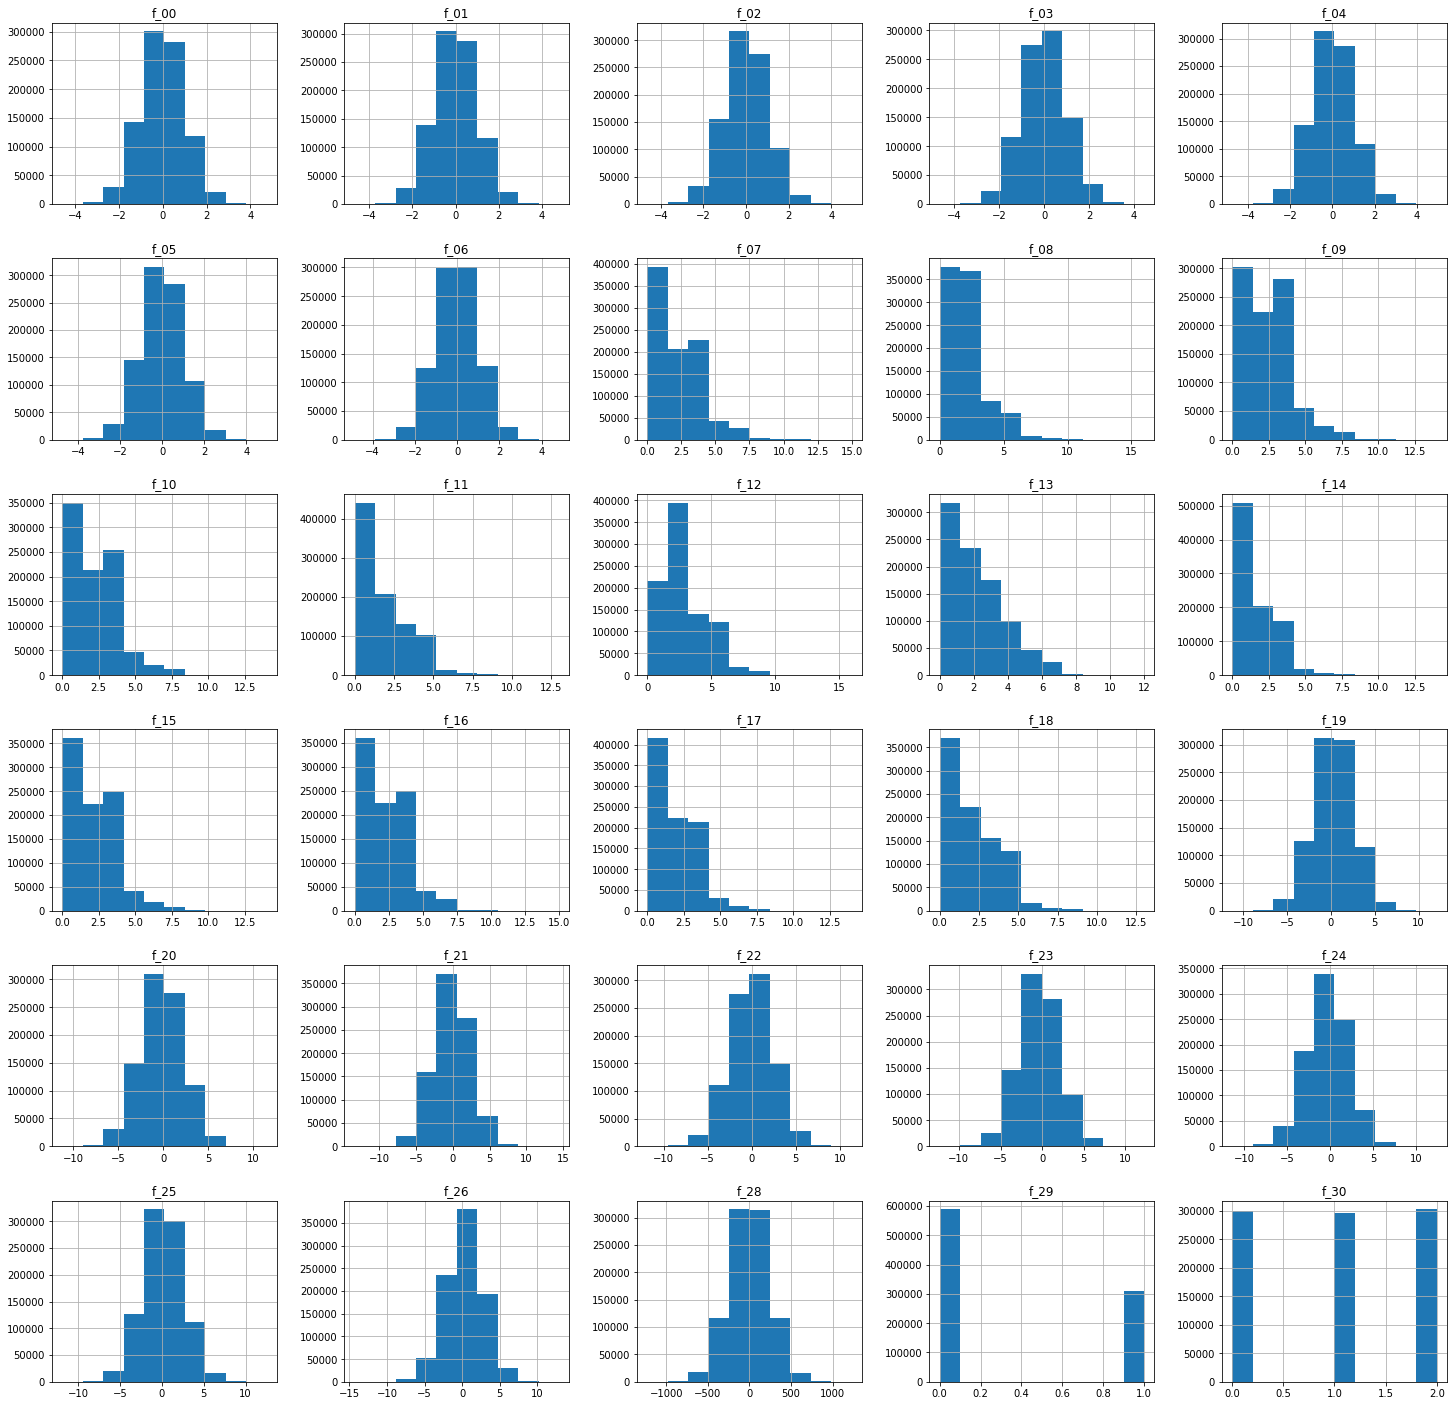

In [10]:
train_df[numerical_columns].hist(figsize=(25,25))

## Here are the some observations from the above plot:<br> 
*     ### It can be noticed that the numerical features are not uniformly scaled.
     * #### <b>For instance, "f_28" ranges between -1000 to 1000 whereas many other features lie either between -4 to 4 or -10 to 10.</b>
     * #### <b>Also, features "f_07" to "f_18" are left skewed while other features appear to be normally distributed.</b>
*    ### Most importantly, since the base algorithm will be XGBoost, it is not required to perform scaling.

In [43]:
train_df["kfold"] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)
X,y = train_df.drop('target',axis=1),train_df.target

In [44]:
X.shape,y.shape

((900000, 33), (900000,))

### Performing Stratified K-Fold validation with 10 splits

In [45]:
kfold = model_selection.StratifiedKFold(n_splits=10,shuffle=True)

In [46]:
for fold,(train_index,valid_index) in enumerate(kfold.split(X=X,y=y)):
    train_df.loc[valid_index,'kfold'] = fold
train_df.to_csv("train_folds.csv",index=False)

In [47]:
useful_cols = [col for col in train_df.columns if col not in ('id','kfold','f_27','target')]
useful_cols

['f_00',
 'f_01',
 'f_02',
 'f_03',
 'f_04',
 'f_05',
 'f_06',
 'f_07',
 'f_08',
 'f_09',
 'f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_28',
 'f_29',
 'f_30']

In [48]:
df_folds = pd.read_csv("./train_folds.csv")

In [49]:
df_folds.shape

(900000, 34)

#### Finding the optimal hyperparameter values by using fold 0 data.

In [50]:
def run(trial):
    fold = 0
    # Defining the hyperparameters 
    n_estimators = trial.suggest_int("n_estimators",1000,10000)
    learning_rate = trial.suggest_float("learning_rate",0.01,0.25,log=True)
    max_depth = trial.suggest_int("max_depth",1,10)
    reg_lambda = trial.suggest_loguniform("reg_lambda",1e-8,100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha",1e-8,100.0)
    subsample = trial.suggest_float("subsample",0.1,1.0)
    colsample_bytree = trial.suggest_float("subsample",0.1,1.0)
    
    df_train = df_folds[df_folds.kfold!=fold].reset_index(drop=True)
    df_validation = df_folds[df_folds.kfold==fold].reset_index(drop=True)
    
    X_train,Y_train = df_train.drop(['target'],axis=1),df_train.target
    X_valid,Y_valid = df_validation.drop(['target'],axis=1),df_validation.target
    
    X_train,X_valid = X_train[useful_cols],X_valid[useful_cols]
    
    # Building the model 
    model = XGBClassifier(
                                tree_method="gpu_hist",gpu_id=1,predictor="gpu_predictor",
                                n_estimators=n_estimators,learning_rate=learning_rate,max_depth=max_depth,
                                reg_lambda=reg_lambda,reg_alpha=reg_alpha,subsample=subsample,colsample_bytree=colsample_bytree 
                             )
    
    model.fit(X_train,Y_train,early_stopping_rounds=500,eval_set=[(X_valid,Y_valid)],verbose=1000)
    Y_pred_valid = model.predict(X_valid)
    accuracy = metrics.accuracy_score(Y_valid,Y_pred_valid)
    print(f'Accuracy on validation data: {accuracy}')  
    return accuracy

In [51]:
study = optuna.create_study(direction="maximize")
study.optimize(run,n_trials=25)

[I 2022-05-12 18:49:54,942] A new study created in memory with name: no-name-83fbd633-556f-40a4-a6f7-665c360e6bb4
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:49:56] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.69057
[1000]	validation_0-logloss:0.38860
[2000]	validation_0-logloss:0.35754
[3000]	validation_0-logloss:0.34802
[4000]	validation_0-logloss:0.34298
[5000]	validation_0-logloss:0.34002
[5585]	validation_0-logloss:0.33879


[I 2022-05-12 18:50:44,725] Trial 0 finished with value: 0.8690666666666667 and parameters: {'n_estimators': 5586, 'learning_rate': 0.04808606049414582, 'max_depth': 6, 'reg_lambda': 5.046399764921015e-06, 'reg_alpha': 5.305467962110433, 'subsample': 0.4209480084464384}. Best is trial 0 with value: 0.8690666666666667.


Accuracy on validation data: 0.8690666666666667


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:50:46] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.69287
[1000]	validation_0-logloss:0.60804
[2000]	validation_0-logloss:0.57807
[2798]	validation_0-logloss:0.56320


[I 2022-05-12 18:50:56,788] Trial 1 finished with value: 0.7298666666666667 and parameters: {'n_estimators': 2799, 'learning_rate': 0.014947231532428296, 'max_depth': 2, 'reg_lambda': 0.02879586602987321, 'reg_alpha': 0.00010065584923268988, 'subsample': 0.4909863476628481}. Best is trial 0 with value: 0.8690666666666667.


Accuracy on validation data: 0.7298666666666667


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:50:57] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.69054
[1000]	validation_0-logloss:0.38856
[2000]	validation_0-logloss:0.35657
[3000]	validation_0-logloss:0.34660
[4000]	validation_0-logloss:0.34202
[5000]	validation_0-logloss:0.33928
[6000]	validation_0-logloss:0.33749
[7000]	validation_0-logloss:0.33634
[8000]	validation_0-logloss:0.33539
[9000]	validation_0-logloss:0.33461
[9548]	validation_0-logloss:0.33425


[I 2022-05-12 18:53:33,400] Trial 2 finished with value: 0.8705333333333334 and parameters: {'n_estimators': 9549, 'learning_rate': 0.022686760292125976, 'max_depth': 9, 'reg_lambda': 2.4631280847000846e-05, 'reg_alpha': 54.455111471822256, 'subsample': 0.5500716939507473}. Best is trial 2 with value: 0.8705333333333334.


Accuracy on validation data: 0.8705333333333334


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:53:34] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.69291
[1000]	validation_0-logloss:0.58481
[2000]	validation_0-logloss:0.54761
[3000]	validation_0-logloss:0.52528
[3341]	validation_0-logloss:0.51809


[I 2022-05-12 18:53:48,854] Trial 3 finished with value: 0.7717777777777778 and parameters: {'n_estimators': 3342, 'learning_rate': 0.011049493093609026, 'max_depth': 3, 'reg_lambda': 0.004552277523999746, 'reg_alpha': 1.057674729782253e-06, 'subsample': 0.400346498108188}. Best is trial 2 with value: 0.8705333333333334.


Accuracy on validation data: 0.7717777777777778


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:53:50] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.68839
[1000]	validation_0-logloss:0.36797
[2000]	validation_0-logloss:0.35565
[3000]	validation_0-logloss:0.35435
[3546]	validation_0-logloss:0.35528


[I 2022-05-12 18:54:32,253] Trial 4 finished with value: 0.8593111111111111 and parameters: {'n_estimators': 4486, 'learning_rate': 0.08665453546876205, 'max_depth': 7, 'reg_lambda': 0.0003282359577576183, 'reg_alpha': 0.08067036403028227, 'subsample': 0.31958788273536953}. Best is trial 2 with value: 0.8705333333333334.


Accuracy on validation data: 0.8593111111111111


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:54:33] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.69192
[1000]	validation_0-logloss:0.62186
[1438]	validation_0-logloss:0.62190


[I 2022-05-12 18:54:38,226] Trial 5 finished with value: 0.6490111111111111 and parameters: {'n_estimators': 9398, 'learning_rate': 0.2183498299341731, 'max_depth': 1, 'reg_lambda': 4.986078908810462, 'reg_alpha': 0.2839415624857724, 'subsample': 0.11613254643420286}. Best is trial 2 with value: 0.8705333333333334.


Accuracy on validation data: 0.6490111111111111


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:54:39] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.69301
[1000]	validation_0-logloss:0.65593
[2000]	validation_0-logloss:0.64380
[3000]	validation_0-logloss:0.63710
[4000]	validation_0-logloss:0.63287
[4327]	validation_0-logloss:0.63182


[I 2022-05-12 18:54:52,649] Trial 6 finished with value: 0.6450111111111111 and parameters: {'n_estimators': 4328, 'learning_rate': 0.013023708055084848, 'max_depth': 1, 'reg_lambda': 2.9987242059097094e-05, 'reg_alpha': 1.0714096597570775, 'subsample': 0.9732193960728954}. Best is trial 2 with value: 0.8705333333333334.


Accuracy on validation data: 0.6450111111111111


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:54:53] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.68771
[1000]	validation_0-logloss:0.36202
[2000]	validation_0-logloss:0.33894
[3000]	validation_0-logloss:0.33260
[4000]	validation_0-logloss:0.32979
[5000]	validation_0-logloss:0.32853
[6000]	validation_0-logloss:0.32792
[6841]	validation_0-logloss:0.32775


[I 2022-05-12 18:55:52,786] Trial 7 finished with value: 0.8753444444444445 and parameters: {'n_estimators': 9789, 'learning_rate': 0.05246326235995674, 'max_depth': 6, 'reg_lambda': 0.005160154696080407, 'reg_alpha': 0.05468983629573752, 'subsample': 0.6463028885657155}. Best is trial 7 with value: 0.8753444444444445.


Accuracy on validation data: 0.8753444444444445


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:55:53] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.68445
[1000]	validation_0-logloss:0.33511
[2000]	validation_0-logloss:0.32627
[3000]	validation_0-logloss:0.32438
[4000]	validation_0-logloss:0.32436
[4161]	validation_0-logloss:0.32437


[I 2022-05-12 18:56:29,694] Trial 8 finished with value: 0.8775222222222222 and parameters: {'n_estimators': 6510, 'learning_rate': 0.09435221396090392, 'max_depth': 6, 'reg_lambda': 0.15172024077312227, 'reg_alpha': 6.960561267621626e-05, 'subsample': 0.9512730575880284}. Best is trial 8 with value: 0.8775222222222222.


Accuracy on validation data: 0.8775222222222222


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:56:30] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.69259
[1000]	validation_0-logloss:0.52635
[2000]	validation_0-logloss:0.48208
[3000]	validation_0-logloss:0.45436
[4000]	validation_0-logloss:0.43604
[5000]	validation_0-logloss:0.42406
[6000]	validation_0-logloss:0.41525
[7000]	validation_0-logloss:0.40860
[8000]	validation_0-logloss:0.40350
[8855]	validation_0-logloss:0.39982


[I 2022-05-12 18:57:27,864] Trial 9 finished with value: 0.8372444444444445 and parameters: {'n_estimators': 8856, 'learning_rate': 0.021425516526593278, 'max_depth': 5, 'reg_lambda': 7.83647556852222, 'reg_alpha': 0.4479736544822238, 'subsample': 0.19878703419710775}. Best is trial 8 with value: 0.8775222222222222.


Accuracy on validation data: 0.8372444444444445


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:57:29] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.65820
[810]	validation_0-logloss:0.34570


[I 2022-05-12 18:58:06,592] Trial 10 finished with value: 0.8766333333333334 and parameters: {'n_estimators': 7063, 'learning_rate': 0.19984828124283255, 'max_depth': 10, 'reg_lambda': 2.4451677106469612e-08, 'reg_alpha': 4.986185261371608e-07, 'subsample': 0.9317519170697575}. Best is trial 8 with value: 0.8775222222222222.


Accuracy on validation data: 0.8766333333333334


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:58:07] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.65421
[733]	validation_0-logloss:0.34685


[I 2022-05-12 18:58:43,459] Trial 11 finished with value: 0.8767111111111111 and parameters: {'n_estimators': 6968, 'learning_rate': 0.22121299592985913, 'max_depth': 10, 'reg_lambda': 1.1774676773951946e-08, 'reg_alpha': 2.8327064965533522e-08, 'subsample': 0.9717953784138992}. Best is trial 8 with value: 0.8775222222222222.


Accuracy on validation data: 0.8767111111111111


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:58:44] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.67725
[1000]	validation_0-logloss:0.32302
[1022]	validation_0-logloss:0.32300


[I 2022-05-12 18:59:04,052] Trial 12 finished with value: 0.8787888888888888 and parameters: {'n_estimators': 1023, 'learning_rate': 0.11093261865088706, 'max_depth': 8, 'reg_lambda': 1.0520214944560529e-08, 'reg_alpha': 1.5203113576305653e-08, 'subsample': 0.7780755310960275}. Best is trial 12 with value: 0.8787888888888888.


Accuracy on validation data: 0.8787888888888888


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:59:05] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.67828
[1000]	validation_0-logloss:0.32330
[2000]	validation_0-logloss:0.32414
[2067]	validation_0-logloss:0.32437


[I 2022-05-12 18:59:44,253] Trial 13 finished with value: 0.8783222222222222 and parameters: {'n_estimators': 6641, 'learning_rate': 0.10468216594881265, 'max_depth': 8, 'reg_lambda': 0.15255780368532457, 'reg_alpha': 0.0012497172978138055, 'subsample': 0.7533886107184863}. Best is trial 12 with value: 0.8787888888888888.


Accuracy on validation data: 0.8783222222222222


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[18:59:45] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.67679
[1000]	validation_0-logloss:0.32375
[1013]	validation_0-logloss:0.32382


[I 2022-05-12 19:00:04,695] Trial 14 finished with value: 0.8778222222222222 and parameters: {'n_estimators': 1014, 'learning_rate': 0.11439606089410408, 'max_depth': 8, 'reg_lambda': 4.0095137392837485e-07, 'reg_alpha': 0.0023494153264540965, 'subsample': 0.7875475310137177}. Best is trial 12 with value: 0.8787888888888888.


Accuracy on validation data: 0.8778222222222222


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19:00:05] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.67553
[1000]	validation_0-logloss:0.32438
[1471]	validation_0-logloss:0.32596


[I 2022-05-12 19:00:33,737] Trial 15 finished with value: 0.8766555555555555 and parameters: {'n_estimators': 1472, 'learning_rate': 0.12724881196607055, 'max_depth': 8, 'reg_lambda': 0.6016940889207048, 'reg_alpha': 0.0007092016071037755, 'subsample': 0.7620224934314408}. Best is trial 12 with value: 0.8787888888888888.


Accuracy on validation data: 0.8766555555555555


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19:00:35] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.69086
[1000]	validation_0-logloss:0.42357
[2000]	validation_0-logloss:0.37954
[2308]	validation_0-logloss:0.37280


[I 2022-05-12 19:00:47,172] Trial 16 finished with value: 0.8531444444444445 and parameters: {'n_estimators': 2309, 'learning_rate': 0.054396503509147535, 'max_depth': 4, 'reg_lambda': 28.957674707785223, 'reg_alpha': 3.59755805712475e-06, 'subsample': 0.785668708300188}. Best is trial 12 with value: 0.8787888888888888.


Accuracy on validation data: 0.8531444444444445


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19:00:48] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.67254
[1000]	validation_0-logloss:0.33278
[1188]	validation_0-logloss:0.33358


[I 2022-05-12 19:01:10,734] Trial 17 finished with value: 0.8735888888888889 and parameters: {'n_estimators': 7824, 'learning_rate': 0.14333473060163085, 'max_depth': 8, 'reg_lambda': 0.0004105349664827356, 'reg_alpha': 1.045979099754233e-08, 'subsample': 0.639373241940496}. Best is trial 12 with value: 0.8787888888888888.


Accuracy on validation data: 0.8735888888888889


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19:01:11] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.67963
[1000]	validation_0-logloss:0.31694
[1694]	validation_0-logloss:0.31723


[I 2022-05-12 19:02:02,172] Trial 18 finished with value: 0.8822333333333333 and parameters: {'n_estimators': 5391, 'learning_rate': 0.0787695908708863, 'max_depth': 9, 'reg_lambda': 2.547242030510146e-07, 'reg_alpha': 0.005185555843499701, 'subsample': 0.8496725929649038}. Best is trial 18 with value: 0.8822333333333333.


Accuracy on validation data: 0.8822333333333333


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19:02:03] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.68737
[1000]	validation_0-logloss:0.33165
[2000]	validation_0-logloss:0.31620
[3000]	validation_0-logloss:0.31338
[4000]	validation_0-logloss:0.31303
[4343]	validation_0-logloss:0.31361


[I 2022-05-12 19:04:11,826] Trial 19 finished with value: 0.8834666666666666 and parameters: {'n_estimators': 4481, 'learning_rate': 0.03291434857101675, 'max_depth': 9, 'reg_lambda': 1.6315155987109948e-07, 'reg_alpha': 2.887040587117406e-05, 'subsample': 0.8647176282771512}. Best is trial 19 with value: 0.8834666666666666.


Accuracy on validation data: 0.8834666666666666


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19:04:13] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.68474
[1000]	validation_0-logloss:0.31828
[2000]	validation_0-logloss:0.31233
[2618]	validation_0-logloss:0.31293


[I 2022-05-12 19:06:15,427] Trial 20 finished with value: 0.8835111111111111 and parameters: {'n_estimators': 5018, 'learning_rate': 0.040741575151457356, 'max_depth': 10, 'reg_lambda': 4.082308298772084e-07, 'reg_alpha': 0.009667259520190858, 'subsample': 0.8765614239031079}. Best is trial 20 with value: 0.8835111111111111.


Accuracy on validation data: 0.8835111111111111


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19:06:16] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.68609
[1000]	validation_0-logloss:0.32181
[2000]	validation_0-logloss:0.31229
[2844]	validation_0-logloss:0.31214


[I 2022-05-12 19:08:31,500] Trial 21 finished with value: 0.8841555555555556 and parameters: {'n_estimators': 5058, 'learning_rate': 0.03408792547508642, 'max_depth': 10, 'reg_lambda': 3.568206318994946e-07, 'reg_alpha': 0.009950501391039123, 'subsample': 0.8764111561807713}. Best is trial 21 with value: 0.8841555555555556.


Accuracy on validation data: 0.8841555555555556


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19:08:32] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.68519
[1000]	validation_0-logloss:0.31851
[2000]	validation_0-logloss:0.31183
[2842]	validation_0-logloss:0.31246


[I 2022-05-12 19:10:46,684] Trial 22 finished with value: 0.8848888888888888 and parameters: {'n_estimators': 4526, 'learning_rate': 0.038442373775622506, 'max_depth': 10, 'reg_lambda': 4.4146229302758256e-07, 'reg_alpha': 3.2287428442732536e-05, 'subsample': 0.8711371422200682}. Best is trial 22 with value: 0.8848888888888888.


Accuracy on validation data: 0.8848888888888888


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19:10:47] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.68654
[1000]	validation_0-logloss:0.32605
[2000]	validation_0-logloss:0.31660
[2833]	validation_0-logloss:0.31639


[I 2022-05-12 19:13:01,333] Trial 23 finished with value: 0.8815777777777778 and parameters: {'n_estimators': 5476, 'learning_rate': 0.03539956585445244, 'max_depth': 10, 'reg_lambda': 3.5823407106845696e-06, 'reg_alpha': 0.023098783034587494, 'subsample': 0.6690860591422096}. Best is trial 22 with value: 0.8848888888888888.


Accuracy on validation data: 0.8815777777777778


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19:13:02] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-logloss:0.68631
[1000]	validation_0-logloss:0.32207
[2000]	validation_0-logloss:0.31193
[3000]	validation_0-logloss:0.31167
[3028]	validation_0-logloss:0.31173


[I 2022-05-12 19:15:24,033] Trial 24 finished with value: 0.8844444444444445 and parameters: {'n_estimators': 3781, 'learning_rate': 0.03291634868772398, 'max_depth': 10, 'reg_lambda': 1.2365325413105453e-06, 'reg_alpha': 0.00016776281056268233, 'subsample': 0.87500131606868}. Best is trial 22 with value: 0.8848888888888888.


Accuracy on validation data: 0.8844444444444445


In [52]:
study.best_params

{'n_estimators': 4526,
 'learning_rate': 0.038442373775622506,
 'max_depth': 10,
 'reg_lambda': 4.4146229302758256e-07,
 'reg_alpha': 3.2287428442732536e-05,
 'subsample': 0.8711371422200682}

In [53]:
test_predictions = []
def run_fold(fold):
    print(f'Processing fold:{fold}')
    df_train = df_folds[df_folds.kfold!=fold].reset_index(drop=True)
    df_validation = df_folds[df_folds.kfold==fold].reset_index(drop=True)
    
    X_train,Y_train = df_train.drop(['target'],axis=1),df_train.target
    X_valid,Y_valid = df_validation.drop(['target'],axis=1),df_validation.target
    
    X_train,X_valid = X_train[useful_cols],X_valid[useful_cols]
    X_test = test_df.copy()
    X_test = X_test[useful_cols]
    
    # Building the model 
    clf = XGBClassifier(tree_method='gpu_hist',gpu_id=1,
                        predictor='gpu_predictor',
                        n_estimators = 4526,
                        learning_rate = 0.038442373775622506,
                        max_depth = 10,
                        reg_lambda = 4.4146229302758256e-07,
                        reg_alpha =  3.2287428442732536e-05,
                        subsample = 0.8711371422200682)
    
    clf.fit(X_train,Y_train)
    Y_pred_valid = clf.predict(X_valid)
    print(f'Accuracy on validation data: {metrics.accuracy_score(Y_valid,Y_pred_valid)}')
    Y_pred_test = clf.predict(X_test)
    test_predictions.append(Y_pred_test)

In [54]:
print('Building an XGB classifier model')
for index in range(10):
    run_fold(index)

Building an XGB classifier model
Processing fold:0
[19:18:27] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
Accuracy on validation data: 0.8853555555555556
Processing fold:1
[19:22:12] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
Accuracy on validation data: 0.8852666666666666
Processing fold:2
[19:25:53] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
Accuracy on validation data: 0.8844
Processing fold:3
[19:29:38] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
Accuracy on validation data: 0.8840555555555556
Processing fold:4
[19:33:15] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
Accuracy on validation data: 0.8836777777777778
Processing fold:5
[19:36:59] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
Accuracy on validation data: 0.886
Processing fold:6
[19:40:39] WARNING: ../src/learner.cc:

In [55]:
final_predictions = np.mean(np.column_stack(test_predictions),axis=1).tolist()

In [56]:
submissions_df = pd.read_csv("../input/tabular-playground-series-may-2022/sample_submission.csv")
submissions_df.target = final_predictions

In [57]:
submissions_df.to_csv("submission2.csv",index=False)